## Product space decision tree

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hyperdt.product_space_DT import ProductSpace, ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


### Generate wrapped normal mixture for product space

In [3]:
NUM_POINTS = 1000
NUM_CLASSES = 4
signature = [(3, -1.), (4, -.5), (7, .5), (6, 1.), (5, 0.)]

In [4]:
ps = ProductSpace(signature, seed=0)
ps.sample_clusters(NUM_POINTS, NUM_CLASSES, cov_scale=0.3)
ps.split_data()

### Fit product space DT and compute predictive accuracy

In [5]:
psdt = ProductSpaceDT(product_space=ps, max_depth=3)
psdt.fit()
psdt.score(ps.X_test, ps.y_test)

0.725

### Benchmark analysis vs sklearn

In [6]:
def compute_scores(signature, n=NUM_POINTS, num_classes=NUM_CLASSES, seed=None, cov_scale=0.3, max_depth=3):
    # Generate data
    ps = ProductSpace(signature, seed=seed)
    ps.sample_clusters(n, num_classes, cov_scale=cov_scale)
    ps.split_data()

    # Fit hyperspace decision tree classifier
    psdt = ProductSpaceDT(product_space=ps, max_depth=max_depth)
    psdt.fit()
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    # Fit sklearn's decision tree classifier
    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    return psdt_score, dt_score

In [7]:
# Experiment with different signatures
signatures = [
    [(3, -1.)],
    [(3, 1.)],
    [(3, -1.), (4, -.5)],
    [(3, -1.), (4, 1.)],
    [(3, -1.), (4, 1.), (5, 0.)],
    # [(3, -1.), (4, -.5), (3, .5), (4, 1.)],
    # [(3, -1.), (4, -.5), (3, .5), (4, 1.), (5, 0.)],
    # [(6, -1.), (6, -.5), (7, .5), (6, 1.), (6, 0.)]
]

In [8]:
def sig_as_str(sig):
    result = ""
    for i, space in enumerate(sig):
        if space[1] < 0:
            result += f"H^{space[0]}(K={space[1]})"
        elif space[1] > 0:
            result += f"S^{space[0]}(K={space[1]})"
        else:
            result += f"E^{space[0]}"
        if i < len(sig) - 1:
            result += " x "
    return result

In [9]:
rnd_seeds = np.random.randint(0, 1000, 10)

psdt_scores_by_signature = []
dt_scores_by_signature = []
for signature in signatures:
    psdt_scores = []
    dt_scores = []
    for seed in rnd_seeds:
        psdt_score, dt_score = compute_scores(signature, seed=seed)
        psdt_scores.append(psdt_score)
        dt_scores.append(dt_score)
    psdt_scores_by_signature.append(psdt_scores)
    dt_scores_by_signature.append(dt_scores)

avg_psdt_scores = [np.mean(scores) for scores in psdt_scores_by_signature]
avg_dt_scores = [np.mean(scores) for scores in dt_scores_by_signature]

In [10]:
def sort_scores(rnd_seeds, psdt_scores, dt_scores):
    sorted_idx = np.argsort(rnd_seeds)
    sorted_rnd_seeds = rnd_seeds[sorted_idx]
    sorted_psdt_scores = np.array(psdt_scores)[sorted_idx]
    sorted_dt_scores = np.array(dt_scores)[sorted_idx]
    return sorted_rnd_seeds, sorted_psdt_scores, sorted_dt_scores

In [11]:
sorted_psdt_scores_by_signature = []
sorted_dt_scores_by_signature = []
sorted_rnd_seeds = None
for psdt_scores, dt_scores in zip(psdt_scores_by_signature, dt_scores_by_signature):
    sorted_rnd_seeds, sorted_psdt_scores, sorted_dt_scores = sort_scores(rnd_seeds, psdt_scores, dt_scores)
    sorted_psdt_scores_by_signature.append(sorted_psdt_scores)
    sorted_dt_scores_by_signature.append(sorted_dt_scores)

In [12]:
diff_scores = [psdt_score - dt_score for psdt_score, dt_score in
               zip(sorted_psdt_scores_by_signature, sorted_dt_scores_by_signature)]

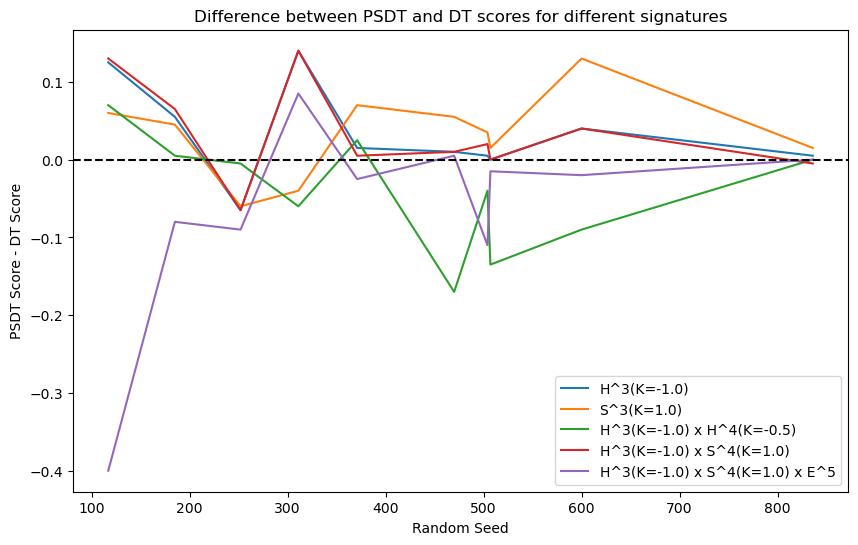

In [15]:
# Plot diff_scores against sorted_rnd_seeds, with each diff_scores[i] as a separate line
plt.figure(figsize=(10, 6))
for i, diff_score in enumerate(diff_scores):
    plt.plot(sorted_rnd_seeds, diff_score, label=f'{sig_as_str(signatures[i])}')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Random Seed')
plt.ylabel('PSDT Score - DT Score')
plt.legend()
plt.title('Difference between PSDT and DT scores for different signatures')
plt.show()

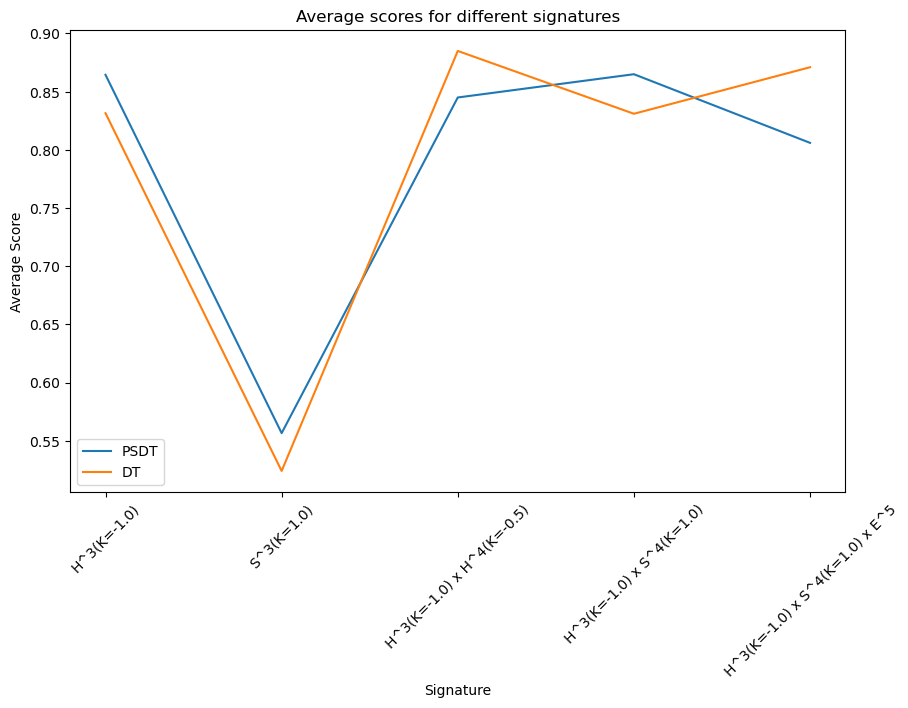

In [14]:
# Plot avg_psdt_scores and avg_dt_scores against signatures
plt.figure(figsize=(10, 6))
plt.plot([sig_as_str(sig) for sig in signatures], avg_psdt_scores, label='PSDT')
plt.plot([sig_as_str(sig) for sig in signatures], avg_dt_scores, label='DT')
plt.xlabel('Signature')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.legend()
plt.title('Average scores for different signatures')
plt.show()